# Step 1 Setup

In [1]:
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    !pip install -Uqq fastai duckduckgo_search

from fastai.vision.all import *
from duckduckgo_search import DDGS
import time

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.3/235.3 kB 4.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 37.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:000:00:010:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.8 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 11.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 61.8 MB/s eta 0:00:00:00:0100:01


# Step 2 Define image search

In [2]:
def search_images(term, max_images=100):
    print(f"Searching for '{term}'")
    return L(DDGS().images(term, max_results=max_images)).itemgot('image')

# Step 3 Download and organise images

In [3]:
# Step 3A: Choose your categories
bear_types = 'grizzly', 'black', 'teddy'

# Step 3B: Create a parent folder
path = Path('bears')

# Step 3C: For each bear type, create a subfolder and download images
if not path.exists():
    path.mkdir()
    for bear in bear_types:
        dest = (path/bear)
        dest.mkdir(exist_ok=True)
        urls = search_images(f'{bear} bear')
        download_images(dest, urls=urls)
        resize_images(dest, max_size=400, dest=dest)

Searching for 'grizzly bear'
Searching for 'black bear'
Searching for 'teddy bear'


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


# Step 4 Create DataLoaders

In [4]:
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128)
)

In [5]:
from fastai.vision.utils import verify_images

# Get all image files again
images = get_image_files(path)

# Verify and remove broken ones
failed = verify_images(images)
print(f"Found {len(failed)} broken images.")
failed.map(Path.unlink);

Found 19 broken images.


In [6]:
dls = bears.dataloaders(path)

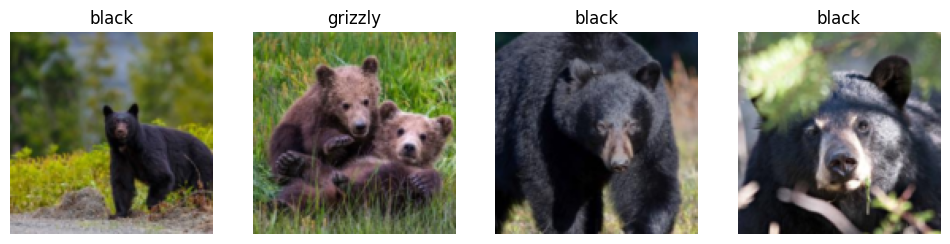

In [7]:
dls.valid.show_batch(max_n=4, nrows=1)

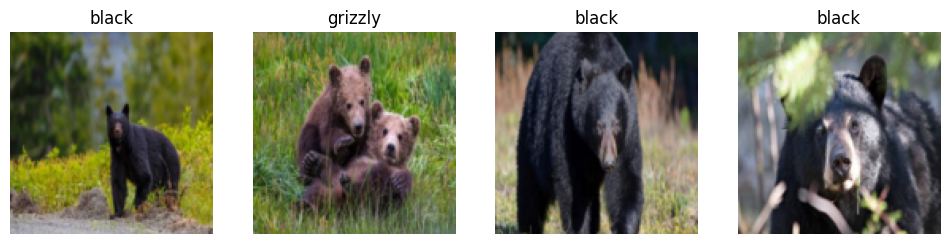

In [8]:
bears = bears.new(item_tfms=Resize(128, method=ResizeMethod.Squish))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

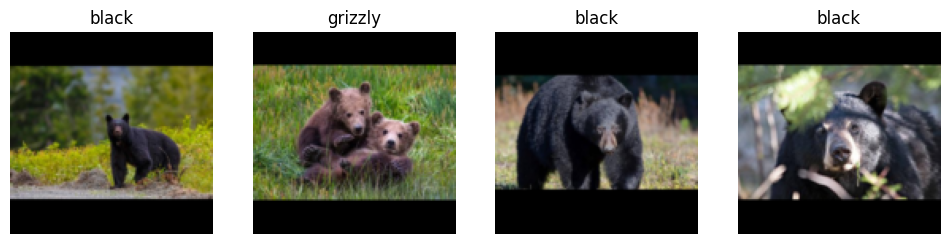

In [9]:
bears = bears.new(item_tfms=Resize(128, method=ResizeMethod.Pad, pad_mode='zeros'))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

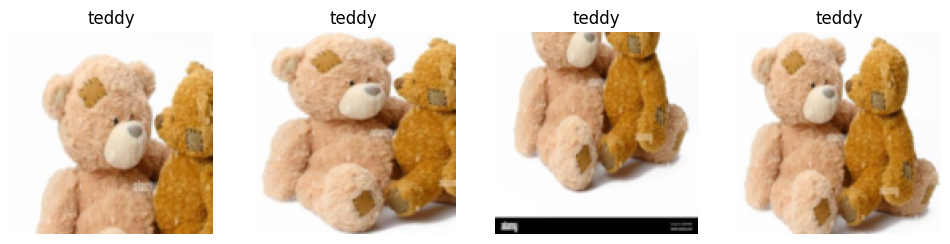

In [10]:
bears = bears.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

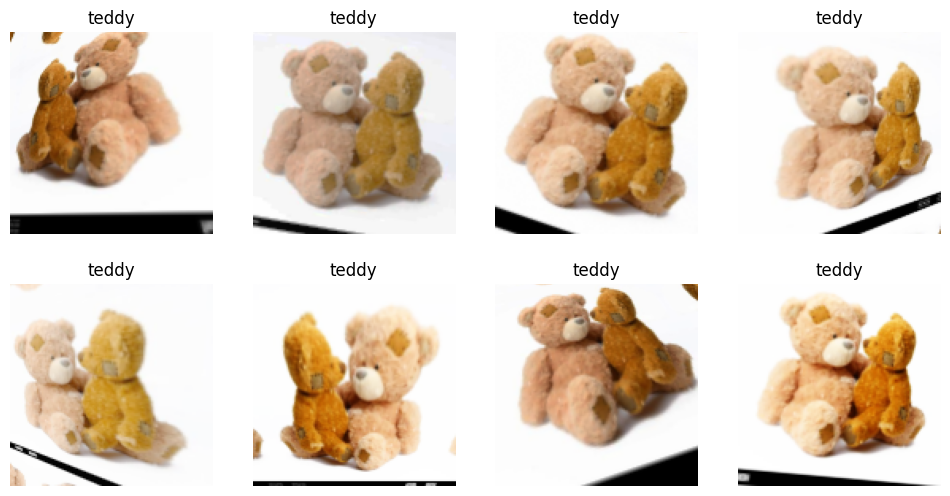

In [11]:
bears = bears.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [12]:
bears = bears.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = bears.dataloaders(path)

In [13]:
from fastai.vision.all import *
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 149MB/s] 


epoch,train_loss,valid_loss,error_rate,time
0,1.750692,0.107911,0.040816,00:10


epoch,train_loss,valid_loss,error_rate,time
0,0.576076,0.014985,0.000000,00:13
1,0.437317,0.003873,0.000000,00:12
2,0.334325,0.003428,0.000000,00:13


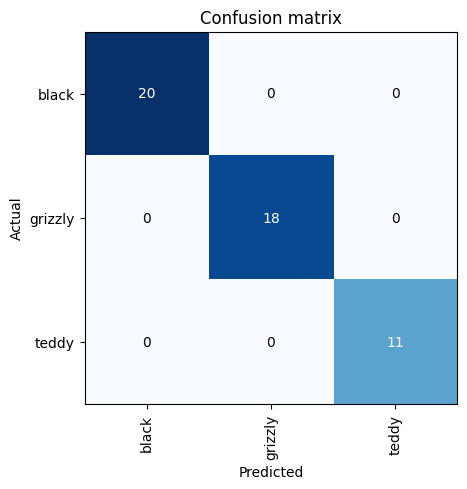

In [14]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

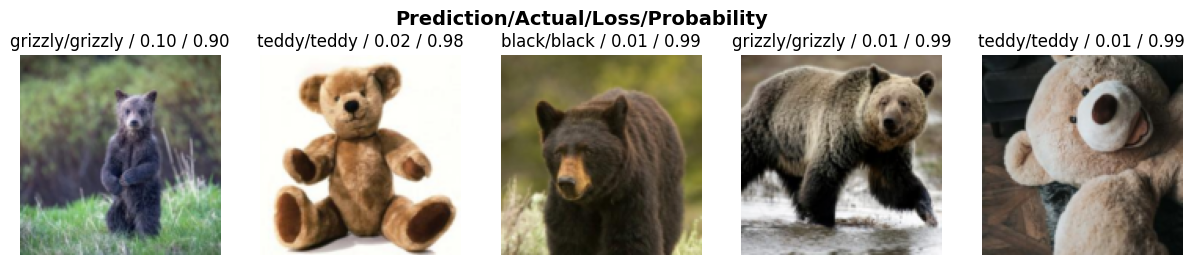

In [16]:
interp.plot_top_losses(5, nrows=1)

In [ ]:
from fastai.vision.widgets import ImageClassifierCleaner

cleaner = ImageClassifierCleaner(learn)
cleaner

In [20]:
get_image_files(path/'grizzly')

(#77) [Path('bears/grizzly/f68ccf96-2cf2-4882-9441-7c115142289c.jpg'),Path('bears/grizzly/572eb693-4a66-459b-8d5f-52920c30a360.jpg'),Path('bears/grizzly/37a0803e-ac78-4f59-8f86-857493e8f0c6.jpg'),Path('bears/grizzly/4b933061-4605-4610-a8a6-060e44edfe94.jpeg'),Path('bears/grizzly/159fa01d-ea06-41bb-89c1-e5c4de5b2d05.jpg'),Path('bears/grizzly/ddbd44e3-04df-430c-a571-300699d544a2.jpg'),Path('bears/grizzly/eb6c2e29-3115-46a2-a9a7-0f81bc476547.jpg'),Path('bears/grizzly/5988518f-9056-4a66-a717-d6f47b20d681.jpg'),Path('bears/grizzly/4bc58daa-1836-41d9-88e5-cb20426d54d4.jpg'),Path('bears/grizzly/a9afb227-e335-430b-9c7d-473abeeaa9e4.jpg'),Path('bears/grizzly/8d5310d8-9fa5-4e21-a220-f46ea8ea3d10.jpg'),Path('bears/grizzly/a7383fad-70d2-40b0-8316-72f65903352e.jpg'),Path('bears/grizzly/836e75f4-9307-4505-8515-17fb0cf953b0.jpg'),Path('bears/grizzly/aa9b6d6f-2bbc-4d39-aa7a-c2d6c2e5b430.jpg'),Path('bears/grizzly/9f92f1f1-b44f-4815-906f-dc0d4771535b.jpg'),Path('bears/grizzly/a4b7bb6b-e45c-4a39-9a2f-c9f

In [22]:
[Path('bears/grizzly/bear123.jpg'), Path('bears/grizzly/image9.png'), ...]

[Path('bears/grizzly/bear123.jpg'), Path('bears/grizzly/image9.png'), Ellipsis]

In [25]:
img = PILImage.create(path/'grizzly'/'f68ccf96-2cf2-4882-9441-7c115142289c.jpg')
learn.predict(img)

('grizzly', tensor(1), tensor([2.7763e-07, 1.0000e+00, 5.4100e-07]))

In [26]:
learn.export('bear_classifier.pkl')